# Performance Assessment for SIC and SIED demonstrated on the SCEPS Polar Scene

**Authors**: T. Lavergne (METNO)

Demonstration notebook [DD-JNB] prepared for TC#2 (Technical Check Point #2)  in the CIMR L2PAD project. The notebook demonstrates preformance assessment of the L2 SI Concentration and Edge algorithms against the SCEPS Polar Scene 1 simulation.

This notebook is adapted from one prepared in the CIMR DEVALGO precursor project.

We compare the outcome of the prototype Level-2 SIC and SIED algorithms against reference data from the the Polar Scene 1 test card prepared by the ESA CIMR SCEPS study. We use the v2.1 simulated L1B file (January 2024). The scene represents a typical winter polar case in the area around Svalbard and the Barents Sea. For the v2.1 simulation, the SIC field used by SCEPS in their simulation is from a model run (NEMO/CICE system).

To prepare the input simulated TBs, the geophysical parameters are first processed through the SCEPS forward simulator to generate Top-of-Atmosphere (TOA) brightness temperatures at all microwave channels, and second through the SCEPS instrument simulator to prepare a simulated L1B file. The input data and various parts of the simulator are documented in SCEPS reports.

## Algorithm Performance Metrics (MPEF)

For SIC, the two main metrics are:
* the **bias** (arithmetic average of the errors)
* the **RMSE** (standard deviation of the errors)

For SIED, an interesting metric is the Integrated Ice Edge Error (**IIEE**) of Goeesling et al. (2016), but this is not implemented in the performance notebook at this stage.

*Goessling, H. F., S. Tietsche, J. J. Day, E. Hawkins, and T. Jung (2016), Predictability of the Arctic sea ice edge, Geophys. Res. Lett., 43, 1642–1650, doi:10.1002/2015GL067232.*


## Test Results using Demonstration Reference Scenario

In [1]:
import sys
import os

import xarray as xr
from netCDF4 import Dataset

import numpy as np
from copy import copy

import pyresample as pr

from matplotlib import pylab as plt
import cartopy.crs as ccrs
import cmocean
import matplotlib

#from sirrdp import rrdp_file
#from pmr_sic import tiepoints as tp

# 'common' software modules to access EASE2 grid definition
sys.path.append('../../')
from common import L2Grids
from common import L2Filename
from common import L2Writer

## Locate DI-TDS-JNB and configuration

The input data for this notebook are organized under [DI-TDS-JNB] (Test Data Set for Jupyter NoteBook). The default is to access this TDS online through thredds / opendap unless the environment variable `CIMR_L2PAD_JNB_TDS` is set. If it is set, it is the path to a local copy of the TDS.

In [2]:
try:
    tds_root = os.environ["CIMR_L2PAD_JNB_TDS"]
    print("Use local TDS: {}".format(tds_root))
except KeyError:
    tds_root = 'https://thredds.met.no/thredds/dodsC/cimr/L2PAD/DI-TDS-JNB_V2D'
    print("Use online TDS: {}".format(tds_root))

Use online TDS: https://thredds.met.no/thredds/dodsC/cimr/L2PAD/DI-TDS-JNB_V2D


### Load SIC and SIED from L2 file

In [3]:
# locate and read the SIC from the L2 netCDF file:
l2_n = '../data/output/DD-JNB_out/CIMR-L2PAD-L2-BRKPT-SeaIceConcentration-NP-NRT3H-20280110115233-fv0.1.nc'

# read the SIC fields from the various SIC algorithms
l2_sic = dict()
l2_rsic = dict()
l2_sied = dict()
galgs = ('KA', 'KKA', 'CKA', 'CKA@KA')
for galg in galgs:
    gname = 'SeaIceConcentration'
    if galg != 'CKA@KA':
        gname = gname + galg
    vname = L2Writer.camel_to_snake(gname)

    with Dataset(l2_n, 'r') as _:
        l2_sic[galg] = _.groups['Data'].groups[gname].variables[vname][0]
        l2_rsic[galg] = _.groups['Data'].groups[gname].variables[vname + '_raw'][0]
        if galg == 'CKA@KA':
            l2_sied[galg] = _.groups['Data'].groups['SeaIceEdge'].variables['sea_ice_edge'][0]

# the grid definition could be read from the L2 file, but we use the definition already loaded in the L2Grids
l2_adef = L2Grids.L2_EASE2['NP_3km']
l2_lon, l2_lat = l2_adef.get_lonlats()

### Load reference SIC from the SCEPS file

In [4]:
# load SIC truth from the GEO file
sceps_file = os.path.join(tds_root, 'CIMR_SIMUL1B_SCEPS', 'cimr_sceps_geo_card_devalgo_polarscene_1_20161217_harmonised_v2p0_surface.nc')
tc_ds = xr.open_dataset(sceps_file)
print("SCEPS GEO file: ", sceps_file)
tc_sic_1km = tc_ds['sea_ice_concentration'][0].to_masked_array().transpose()
tc_lat_1km = tc_ds['latitude'][0].to_masked_array().transpose()
tc_lon_1km = tc_ds['longitude'][0].to_masked_array().transpose()

SCEPS GEO file:  https://thredds.met.no/thredds/dodsC/cimr/L2PAD/DI-TDS-JNB_V2D/CIMR_SIMUL1B_SCEPS/cimr_sceps_geo_card_devalgo_polarscene_1_20161217_harmonised_v2p0_surface.nc


We also mask the SCEPS scene along its sides to avoid contamination of the statistics by out-of-scene TBs.

In [5]:
# how many pixels to mask around the test card
margin = 3
tc_border = np.ones_like(tc_sic_1km).astype('bool')
tc_border[-margin:,:] = False
tc_border[:margin,:] = False
tc_border[:,-margin:] = False
tc_border[:,:margin] = False
tc_sic_1km[~tc_border] = np.ma.masked

Resample the 1x1km SCEPS scene to the L2 3x3km EASE2 grid

In [6]:
tc_sic = L2Grids.remap_latlon_EASE2(tc_sic_1km, tc_lon_1km, tc_lat_1km, 'NP', '3km',
                                          params={'method':'gauss', 'sigmas':2000, 'neighbours':9})

/home/thomasl/mambaforge/envs/py311/lib/python3.11/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 9 neighbours within 5000.0 m for some data points
  get_neighbour_info(source_geo_def,


Finally, compute the reference sea ice edge classification. 

In [7]:
tc_sied = np.ma.where(tc_sic >= 15, 2, 1).astype('byte')

Prepare visualization zoomed on the SCEPS Polar Scene

>>> SCEPS Polar Scene 1 GRID
Area ID: crs
Description: crs
Projection: {'datum': 'WGS84', 'lat_0': '90', 'lon_0': '0', 'no_defs': 'None', 'proj': 'laea', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 1400
Number of rows: 1400
Area extent: (0.0, -100000.0, 1400000.0, -1500000.0)


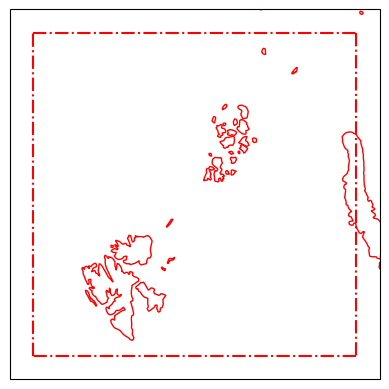

In [8]:
yaml_file = '../data/sceps_polar_scene_1_adef.yaml'
sceps_adef = pr.load_area(yaml_file, 'crs')

print(">>> SCEPS Polar Scene 1 GRID")
print("============================")
print(sceps_adef)

sceps_bbox = sceps_adef.get_bbox_lonlats(vertices_per_side=10,)

def add_sceps_bbox(ax, sceps_bbox):
    for s in range(4):
        _lons = sceps_bbox[0][s]
        _lats = sceps_bbox[1][s]
        ax.plot(_lons, _lats, color='r', ls='-.', transform=ccrs.PlateCarree())
        
fig, ax = plt.subplots(subplot_kw=dict(projection=l2_adef.to_cartopy_crs()))
ax.coastlines(color='red')
ax.set_xlim(-100000,1500000)
ax.set_ylim(-1600000,0)
add_sceps_bbox(ax, sceps_bbox)

### Compare the main L2 SIC (CKA@KA) against the reference SIC

#### Maps of SIC and maps of SIC differences

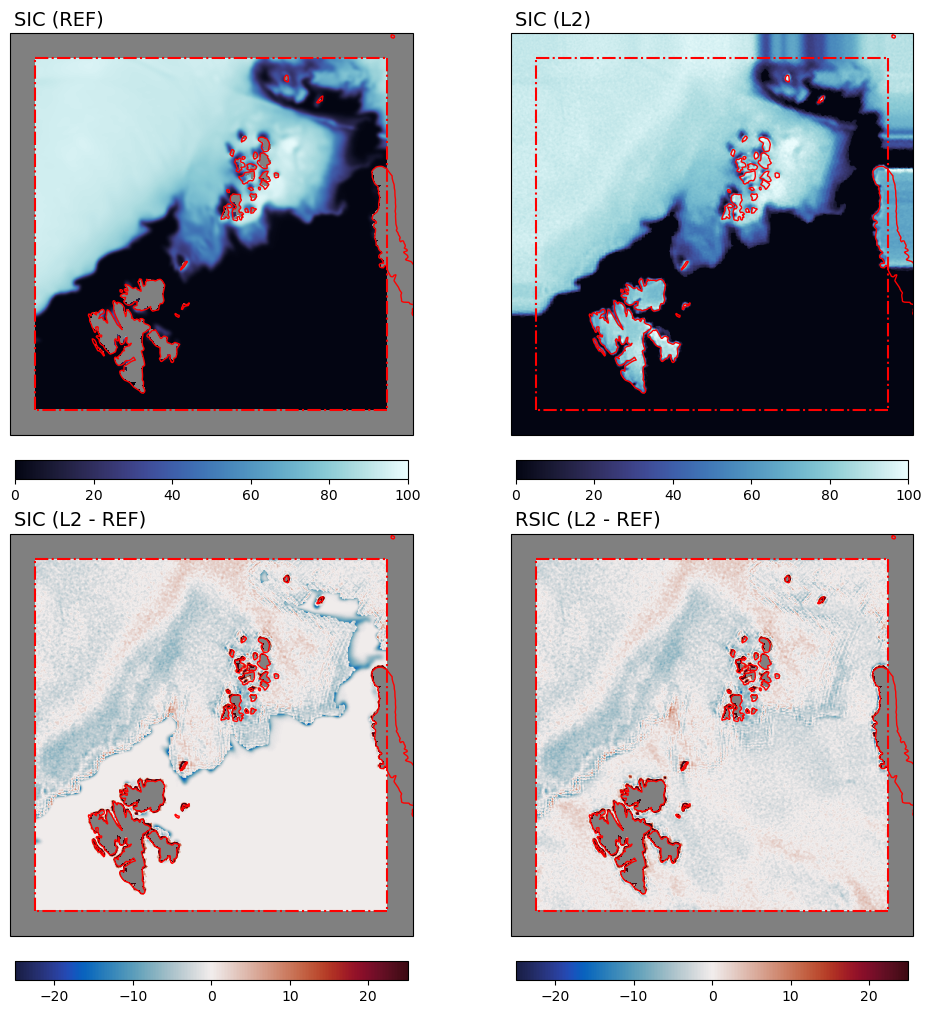

In [9]:
cmap_sic = copy(cmocean.cm.ice)
cmap_sic.set_bad('grey')
vmin = 0
vmax = 100

cmap_dif = copy(cmocean.cm.balance)
cmap_dif.set_bad('grey')
dmin = -25
dmax = -dmin

cart_crs = l2_adef.to_cartopy_crs()

alg = 'CKA@KA'
sic_diff = l2_sic[alg] - tc_sic
rsic_diff = l2_rsic[alg] - tc_sic

# visualize / plot
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10),
                       subplot_kw=dict(projection=cart_crs), layout='constrained')

# first map : SIC Reference
c = ax[0,0].imshow(tc_sic, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap_sic,vmin=vmin,vmax=vmax)

ax[0,0].set_xlim(-100000,1500000)
ax[0,0].set_ylim(-1600000,0)
ax[0,0].coastlines(color='red')
add_sceps_bbox(ax[0,0], sceps_bbox)
ax[0,0].text(0.01,1.01,'SIC (REF)',va='bottom',fontsize=14,transform=ax[0,0].transAxes)
plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.8)

# second map : SIC L2
c = ax[0,1].imshow(l2_sic[alg], transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap_sic,vmin=vmin,vmax=vmax)
ax[0,1].coastlines(color='red')
add_sceps_bbox(ax[0,1], sceps_bbox)
ax[0,1].text(0.01,1.01,'SIC (L2)',va='bottom',fontsize=14,transform=ax[0,1].transAxes)
plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.8)

# third map : SIC diff
c = ax[1,0].imshow(sic_diff, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap_dif,vmin=dmin,vmax=dmax)
ax[1,0].coastlines(color='red')
add_sceps_bbox(ax[1,0], sceps_bbox)
ax[1,0].text(0.01,1.01,'SIC (L2 - REF)',va='bottom',fontsize=14,transform=ax[1,0].transAxes)
plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.8)

# fourth map : rSIC diff
c = ax[1,1].imshow(rsic_diff, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap_dif,vmin=dmin,vmax=dmax)
ax[1,1].coastlines(color='red')
add_sceps_bbox(ax[1,1], sceps_bbox)
ax[1,1].text(0.01,1.01,'RSIC (L2 - REF)',va='bottom',fontsize=14,transform=ax[1,1].transAxes)
plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.8)
plt.show()


The maps above show the Reference SIC (top left), the L2 SIC from `CKA@KA` (Top right), the difference of the two (bottom left), and the difference between the *raw* SIC (still from `CKA@KA` results) and the Reference SIC (bottom right).

Looking at the two first map, it is apparent that the L2 algorithm captures the main features of the Reference SIC field, including in the partial concentration areas north East for Franz Joseph Land (top-right corner of the maps). Details of the sea-ice edge regions seem to be well capture, including in the Barents Sea. The coastal polynyas north for Franz Joseph Land, that are often observed in case of nortwardly winds, is also captured.

Looking at the bottom-left map *(L2 - REF)* we see that differences are both positive and negatives, mostly in the range [-5 ; +5]. The difference is exactly 0% over the ocean, illustrating how the Open Water Filter (OWF) implemented in the L2 SIC algorithm successfully sets SIC to 0% where it detects open water. The most pronounced blue shades (L2 SIC < REF SIC) are seen along the ice edge, which can indicate that the OWF cuts away actual low-concentration sea ice. This is indeed a known caveat of weather filters that they can be too greedy and remove true low-concentration (and/or thin) sea ice (see the description in the ATBD).

The bottom-right map *(RAW L2 - REF)* confirms that the Open Water Filter is the cause of the underestimation seen in the sea-ice edge region in the previous map: the *raw* SIC variable indeed holds the SIC values *before* applying the OWF and the thresholding to the [0 ; 100] range. When OWF is not applied, there is no specific underestimation by the L2 SIC in the marginal ice zone. In this 4th map, the difference is no more exactly 0% over the ocean (since the OWF was not applied to set SICs to 0% there). The differences over the ocean show the actual uncertainty of SIC before the OWF is applied, and is a good indicator of the uncertainty of SIC in the low concentration range.

Next, we will look at histograms and metrics of the differences.

#### Histogram of differences, with BIAS and RMSE (full range of SIC)

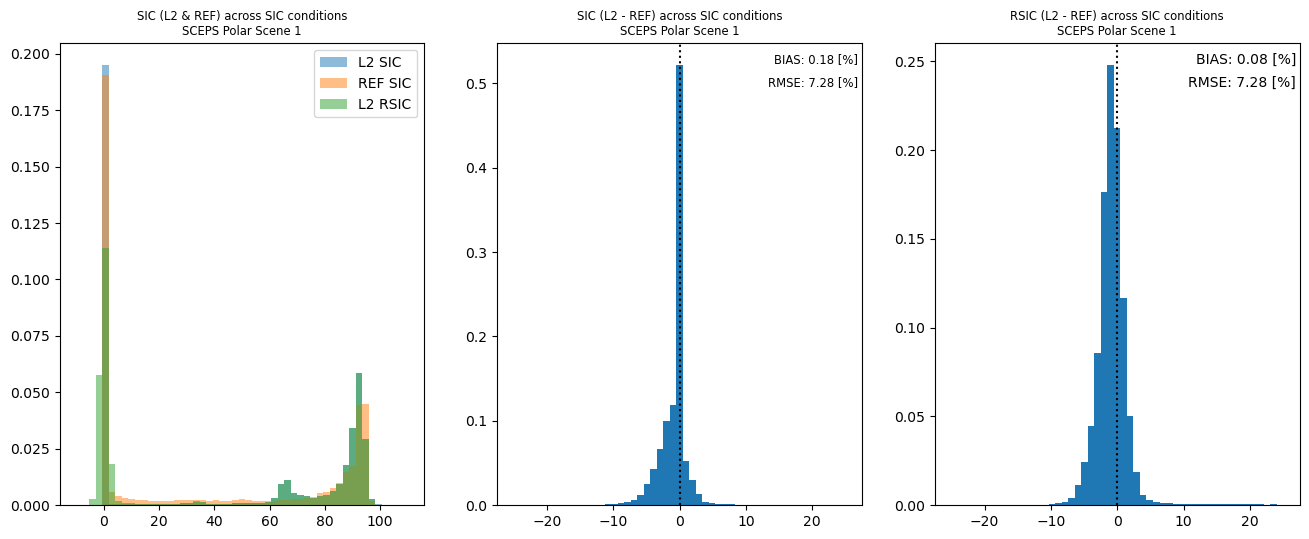

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6),)

nbins=51

ax[0].hist(l2_sic[alg].flatten(), bins=nbins, range=[-10,110], density=True, alpha=0.5, label='L2 SIC')
ax[0].hist(tc_sic.flatten(), bins=nbins, range=[-10,110], density=True, alpha=0.5, label='REF SIC')
ax[0].hist(l2_rsic[alg].flatten(), bins=nbins, range=[-10,110], density=True, alpha=0.5, label='L2 RSIC')
ax[0].legend()
ax[0].set_title("SIC (L2 & REF) across SIC conditions\nSCEPS Polar Scene 1", fontsize='small')

sic_diff_1d = sic_diff.compressed()
hist_range = (dmin, dmax)
ax[1].axvline(x=0, color='k', linestyle=':')
ax[1].hist(sic_diff_1d, bins=nbins, range=hist_range, density=True)
ax[1].axvline(x=sic_diff_1d.mean(), color='k', linestyle='-', lw=1)
ax[1].set_title("SIC (L2 - REF) across SIC conditions\nSCEPS Polar Scene 1", fontsize='small')
ax[1].text(0.99,0.98, 'BIAS: {:.2f} [%]'.format(np.nanmean(sic_diff_1d)),
        transform=ax[1].transAxes, ha='right', va='top', fontsize='small')
ax[1].text(0.99,0.93, 'RMSE: {:.2f} [%]'.format(np.nanstd(sic_diff_1d)),
        transform=ax[1].transAxes, ha='right', va='top', fontsize='small')


rsic_diff_1d = rsic_diff.compressed()
hist_range = (dmin, dmax)
ax[2].axvline(x=0, color='k', linestyle=':')
ax[2].hist(rsic_diff_1d, bins=nbins, range=hist_range, density=True)
ax[2].axvline(x=rsic_diff_1d.mean(), color='k', linestyle='-', lw=1)
ax[2].set_title("RSIC (L2 - REF) across SIC conditions\nSCEPS Polar Scene 1", fontsize='small')
ax[2].text(0.99,0.98, 'BIAS: {:.2f} [%]'.format(np.nanmean(rsic_diff_1d)),
        transform=ax[2].transAxes, ha='right', va='top', )
ax[2].text(0.99,0.93, 'RMSE: {:.2f} [%]'.format(np.nanstd(rsic_diff_1d)),
        transform=ax[2].transAxes, ha='right', va='top', )

plt.show()

Three histograms are shown above. On the left a comparison of three histograms over the full range of SIC, at the center an histogram of the difference between L2 SIC (`CKA@KA` SIC) and the Reference SIC, to the right an histogram of the difference betwen L2 SIC (`CKA@KA` *raw* SIC) and the Reference SIC.

The orange bars (left-most panel) are for the reference SIC as read from the SCEPS GEO files. It shows that the most common value is 0%SIC (over the open ocean). Over consolidated / pack ice, the Reference SIC does not fully reach 100% (which we would have expected for a mid-December conditions in the Arctic). The blue bars (left-most panel) are for the *filtered* L2 SIC, after applying the OWF. We observe a good match at 0% SIC, while the SIC over consolidated / pack ice is slightly lower than the Reference SIC. The green bars (lef-most panel) are for the *non-filtered* (raw) SICs and show more spread around 0% SIC, including negative SIC values. These are the values that are set to 0% by the OWF in the *filtered* SIC (blue bars). At consolidate / pack ice conditions, the green bars exactly overlap the blue bars since the OWF does not modify SICs at high concentrations, and because the Reference SIC does not reach to 100%. In actual retrieval conditions, the blue bars would show more values at 100% SIC, and the green bars would show SICs higher than 100%.

The histogram plot in the center panel reveals that SIC differences are almost entirely contained in the [-10 ; +10] range. The computed RMSE is 7.28%. This histogram has a high peak at 0% (difference) which mostly corresponds to the action of the OWF over the ocean.

The histogram plot in the right panel is for the difference betwen L2 SIC (`CKA@KA` *raw* SIC) and the Reference SIC reveals that SIC differences are almost entirely contained in the [-10 ; +10] range. The computed RMSE is 7.8% and the bias is small, below 0.1%.

#### Histogram of differences, with BIAS and RMSE over pure Open Water and Closed Ice conditions

Next we look at histograms and validation metrics for the two ends of the SIC range: Open Water and Consolidated Ice. We first show a map of the regions where the Open Water and Closed Ice conditions are extracted from:

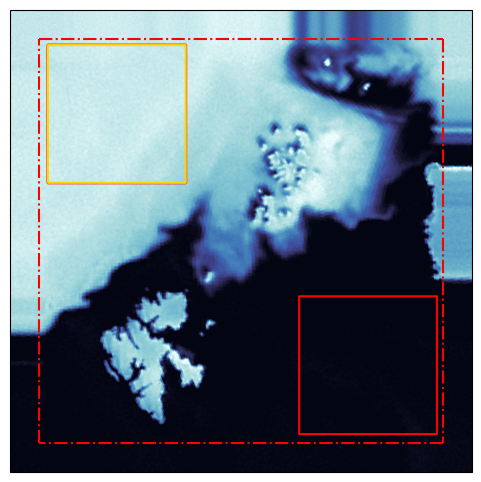

In [11]:
fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(projection=cart_crs))

owci_flg_cice = 2
owci_flg_ow   = 1

tc_owci = np.zeros_like(tc_sic).astype('int')
owci_siz = 482//3
# OW box:
tc_owci[2130:2130+owci_siz,-1500:-1500+owci_siz] = owci_flg_ow
# CI box:
tc_owci[-1760:-1760+owci_siz,1810:1810+owci_siz] = owci_flg_cice


ax.imshow(l2_rsic[alg], transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap_sic,vmin=vmin,vmax=vmax)
ax.contour(tc_owci, levels=(0.99, 1.99), colors=('red','gold'), transform=cart_crs, extent=cart_crs.bounds, origin='upper')
add_sceps_bbox(ax, sceps_bbox)
ax.set_xlim(-100000,1500000)
ax.set_ylim(-1600000,0)

plt.show()

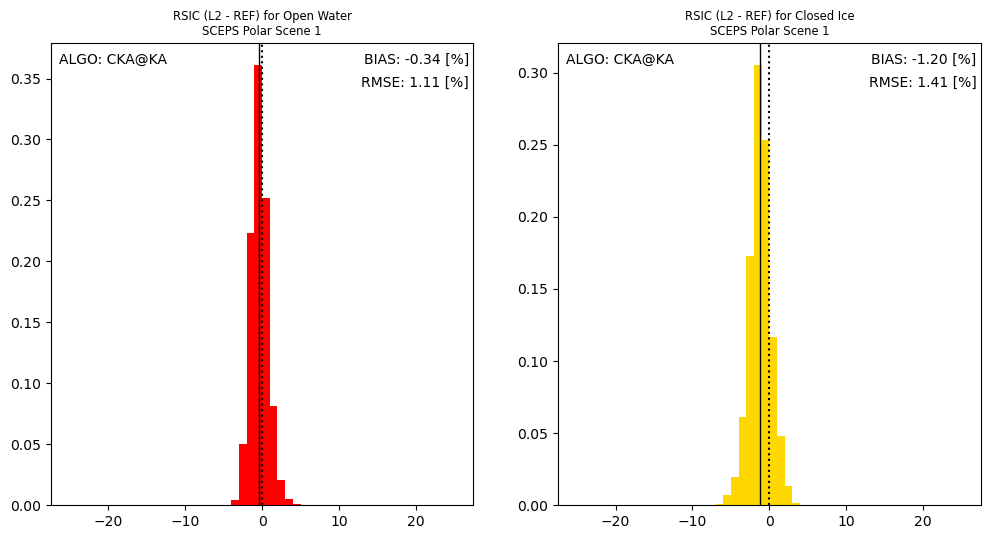

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12,6),)

sic_diff_ow_1d = rsic_diff[tc_owci==1].compressed()
hist_range = (dmin, dmax)
ax[0].axvline(x=0, color='k', linestyle=':')
ax[0].hist(sic_diff_ow_1d, bins=50, range=hist_range, density=True, color='red')
ax[0].axvline(x=sic_diff_ow_1d.mean(), color='k', linestyle='-', lw=1)
ax[0].set_title("RSIC (L2 - REF) for Open Water\nSCEPS Polar Scene 1", fontsize='small')
ax[0].text(0.99,0.98, 'BIAS: {:.2f} [%]'.format(sic_diff_ow_1d.mean()),
        transform=ax[0].transAxes, ha='right', va='top')
ax[0].text(0.99,0.93, 'RMSE: {:.2f} [%]'.format(sic_diff_ow_1d.std()),
        transform=ax[0].transAxes, ha='right', va='top')
ax[0].text(0.02,0.98, 'ALGO: {}'.format(alg.upper()),
            transform=ax[0].transAxes, ha='left', va='top')

sic_diff_ci_1d = rsic_diff[tc_owci==2].compressed()
hist_range = (dmin, dmax)
ax[1].axvline(x=0, color='k', linestyle=':')
ax[1].hist(sic_diff_ci_1d, bins=50, range=hist_range, density=True, color='gold')
ax[1].axvline(x=sic_diff_ci_1d.mean(), color='k', linestyle='-', lw=1)
ax[1].set_title("RSIC (L2 - REF) for Closed Ice\nSCEPS Polar Scene 1", fontsize='small')
ax[1].text(0.99,0.98, 'BIAS: {:.2f} [%]'.format(sic_diff_ci_1d.mean()),
        transform=ax[1].transAxes, ha='right', va='top')
ax[1].text(0.99,0.93, 'RMSE: {:.2f} [%]'.format(sic_diff_ci_1d.std()),
        transform=ax[1].transAxes, ha='right', va='top')
ax[1].text(0.02,0.98, 'ALGO: {}'.format(alg.upper()),
            transform=ax[1].transAxes, ha='left', va='top')
plt.show()

The two histograms above show the difference between the *unfiltered* (*raw*) SIC from L2 to the Reference SIC over Open Water conditions (left panel, red) and Closed Ice (right panel, yellow). We remind that the Reference SIC over Closed Ice conditions is not 100% but rather in the 85 - 95% range.

The two histograms report the retrieval accuracy away from the marginal ice zone, which is how SIC retrieval algorithms are typically evaluated because it is difficult to obtain realistic reference measurements of intermediate SIC conditions that are perfectly collocated in time with satellite acquisition.

The bias reported for Open Water conditions (left panel) is small (-0.3 % SIC). This is expected since the SIC algorithm was partly tuned on the simulated CIMR L1B brightness temperatures duringt the Offline Preparation step. Because we only had a single simulated L1B swath available, we had to train the SIC algorithm on the same swath that we applied it to. As covered in the ATBD, the operational setup would be different since the algorithm would be tuned regularly (e.g. daily) against a rolling archive of CIMR swaths (typically 5-7 past days) and not directly on the swath being processed. Nonetheless, experience of such dynamic tuning in the context of the ESA CCI or OSI SAF products show that low bias (< 0.5%) can be achieved with the dynamic tuning over open water conditions.

The bias reported for Closed Ice conditions (right panel) is slithly larger (-1.2 % SIC). Here we remind that the high-concentration range of the SIC algorithm was not trained dynamically against the simulated L1B TBs, but rather directly against the CCI Sea Ice Round-Robin Data Package (RRDP) SIC1 conditions, that collects both AMSR-E and AMSR2 TBs. The tuning is indirect since, to the best of our knowledge, the parametric sea-ice emissivity model used in the SCEPS simulator is also tuned against the same CCI RRDP SIC1 conditions. We could not tune against the simulated TBs because this would have required a significant number of samples over near 100% SIC conditions, while the Reference SIC is in the 85 - 95% range. Experience from the ESA CCI or OSI SAF products show that small (negative) biases can be achieved for high SIC range using dynamic tuning, but that regional biases can remain significant with different sea-ice types (typically negative bias for multiyear-ice conditions and positive biases for first-year ice conditions). The impact of sea-ice type on the performance of the selected L2 SIC algorithm could not be investigated here because the sea-ice emissivity model used to generate the SCEPS Polar Scene 1 (v2.1) does not include a dependency on sea-ice type.

The RMSEs over Open Water and Closed Ice conditions are very similar and are less than 1.5%. This is smaller than the RMSEs reported in previous sections (that were for the whole SIC range at once) and smaller than the target requirement from the CIMR MRD for the L2 SIC product (5%). Such excellent performance are probably because:
1. the OW (red) and CI (yellow) evaluation regions avoid the Marginal Ice Zone and intermediate ice concentration regions, which is where footprint-mismatch and resampling errors have most impact;
2. the simulated TBs do not necessarily cover the typical range of geophysical variability (e.g. wind speeds over the ocean, sea-ice type dependency, etc...).

While staying careful in extrapolating the results above to potential in-flight performances, we note that previous studies, e.g. in OSI SAF and ESA CCI have shown that RMSE < 5% could be achieved (in winter freezing conditions). The `CKA@KA` algorithm applied to CIMR L1B data has a strong potential to achieve the MRD requirements and beyond.

#### Compare SIED with Integrated Ice Edge Error and related metrics

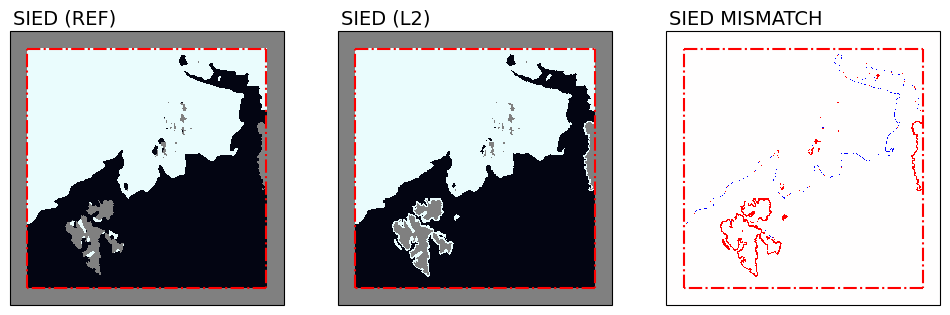

In [13]:
def prepare_IIEE_mask(l2_sied, tc_sied):
        
    Flag_SIE = np.full(np.shape(l2_sied), np.nan)
    Flag_SIE[tc_sied == l2_sied] = 0
    Flag_SIE[tc_sied < l2_sied] = 1
    Flag_SIE[tc_sied > l2_sied] = -1
    Flag_SIE[(tc_sied==np.ma.masked)+(l2_sied==np.ma.masked)] = 0
    
    return Flag_SIE

tc_sied[np.isnan(tc_sic)] = np.ma.masked
l2_sied[alg][np.isnan(tc_sic)] = np.ma.masked
iiee_field = prepare_IIEE_mask(l2_sied[alg], tc_sied)

fig, ax = plt.subplots(figsize=(12,8), ncols=3, sharex=True, sharey=True, subplot_kw=dict(projection=cart_crs))

ax[0].imshow(tc_sied, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap_sic,vmin=1,vmax=2, interpolation='none')
ax[0].text(0.01,1.01,'SIED (REF)',va='bottom',fontsize=14,transform=ax[0].transAxes)
add_sceps_bbox(ax[0], sceps_bbox)
ax[0].set_xlim(-100000,1500000)
ax[0].set_ylim(-1600000,0)

ax[1].imshow(l2_sied[alg], transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap_sic,vmin=1,vmax=2, interpolation='none')
ax[1].text(0.01,1.01,'SIED (L2)',va='bottom',fontsize=14,transform=ax[1].transAxes)
add_sceps_bbox(ax[1], sceps_bbox)

ax[2].imshow(iiee_field, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=matplotlib.cm.bwr,vmin=-1,vmax=1, interpolation='none')
ax[2].text(0.01,1.01,'SIED MISMATCH',va='bottom',fontsize=14,transform=ax[2].transAxes)
add_sceps_bbox(ax[2], sceps_bbox)

plt.show()

The maps above show a zoom of the Reference Sea Ice Edge (SIC > 15%), the L2 SIED (computed by the L2 algorithm based on the `CKA@KA` SIC), and a visualization of the agreement and mismatch between the two. White color is used where both SIED products agree. Blue where the L2 SIED misses sea-ice (underestimation), and red where the L2 SIED overestimates the sea-ice cover.

From this example, it is apparent that the L2 SIED understimates the sea-ice cover in the marginal ice zone, especially in presence of thin sea ice (eastern part of the domain). Conversely, it detects more sea ice than there is along the coasts (land is grey in the left-most panel).

The underestimation is not a surprise and might be a consequence of:
1. the SIED product being computed from the *filtered* SIC field (after OWF);
2. the SIC being currently slightly low-biased because of its non-optimal tuning (see the results on SIC above).

The overstimation along the coastline was also expected and can be improved in the future CIMR L2 processing by:
1. detecting and masking land-dominated FoVs ahead of the SIC processing (currently all FoVs are processed and gridded into the final product);
2. implementing a land/water spill-over correction of the TBs as a pre-processing to the L2 algorithms (including SIC);

#### Performance evaluation of the intermediate SIC results from `CKA`, `KKA` and `KA`

For illustration purposes, we also show the validation statistics obtained from the *intermediate* SIC algorithms.

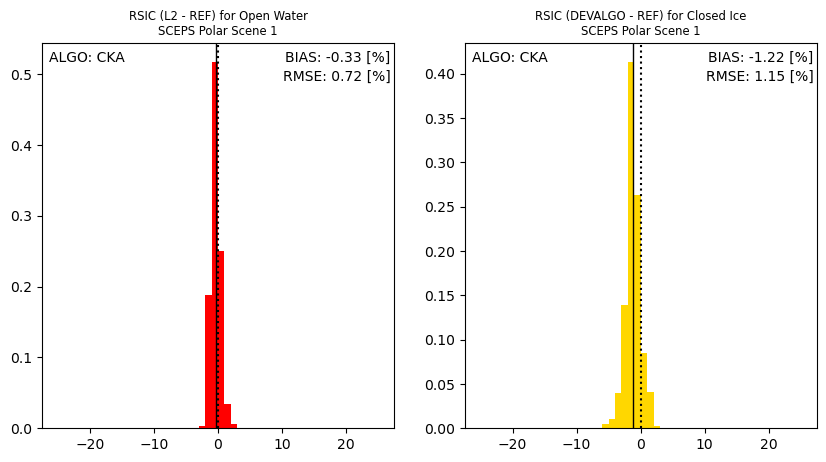

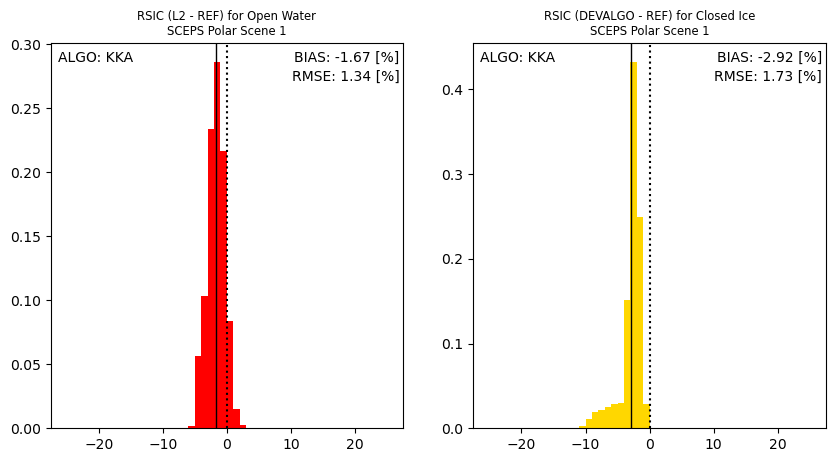

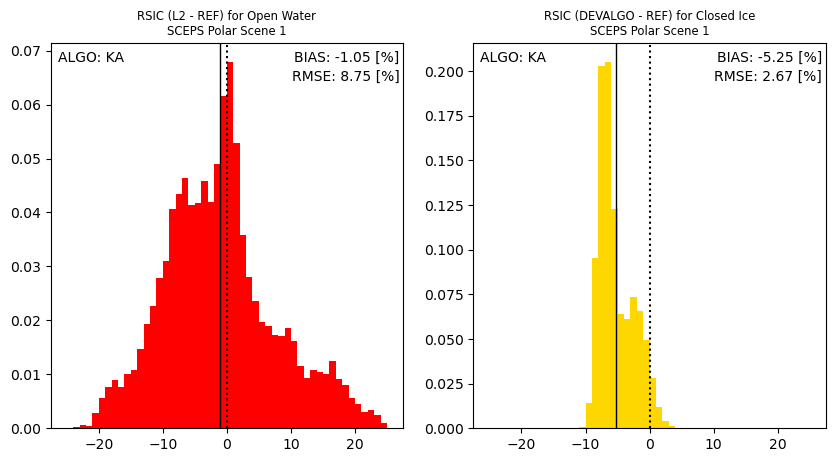

In [14]:
for alg in ('CKA', 'KKA', 'KA'):

    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(10,5),)

    _rsic_diff = l2_rsic[alg] - tc_sic
    
    sic_diff_ow_1d = _rsic_diff[tc_owci==1].compressed()
    hist_range = (dmin, dmax)
    ax[0].axvline(x=0, color='k', linestyle=':')
    ax[0].hist(sic_diff_ow_1d, bins=50, range=hist_range, density=True, color='red')
    ax[0].axvline(x=sic_diff_ow_1d.mean(), color='k', linestyle='-', lw=1)
    ax[0].set_title("RSIC (L2 - REF) for Open Water\nSCEPS Polar Scene 1", fontsize='small')
    ax[0].text(0.99,0.98, 'BIAS: {:.2f} [%]'.format(sic_diff_ow_1d.mean()),
            transform=ax[0].transAxes, ha='right', va='top')
    ax[0].text(0.99,0.93, 'RMSE: {:.2f} [%]'.format(sic_diff_ow_1d.std()),
            transform=ax[0].transAxes, ha='right', va='top')
    ax[0].text(0.02,0.98, 'ALGO: {}'.format(alg.upper()),
            transform=ax[0].transAxes, ha='left', va='top')

    sic_diff_ci_1d = _rsic_diff[tc_owci==2].compressed()
    hist_range = (dmin, dmax)
    ax[1].axvline(x=0, color='k', linestyle=':')
    ax[1].hist(sic_diff_ci_1d, bins=50, range=hist_range, density=True, color='gold')
    ax[1].axvline(x=sic_diff_ci_1d.mean(), color='k', linestyle='-', lw=1)
    ax[1].set_title("RSIC (DEVALGO - REF) for Closed Ice\nSCEPS Polar Scene 1", fontsize='small')
    ax[1].text(0.99,0.98, 'BIAS: {:.2f} [%]'.format(sic_diff_ci_1d.mean()),
            transform=ax[1].transAxes, ha='right', va='top')
    ax[1].text(0.99,0.93, 'RMSE: {:.2f} [%]'.format(sic_diff_ci_1d.std()),
            transform=ax[1].transAxes, ha='right', va='top')
    ax[1].text(0.02,0.98, 'ALGO: {}'.format(alg.upper()),
            transform=ax[1].transAxes, ha='left', va='top')
    plt.show()

The 3 histograms above (top: `CKA`, middle: `KKA`, bottom: `KA`) illustrates well known performance of these algorithms: the performance of SIC algorithm is generally better when it makes use of lower microwave frequencies. 

Here we observe that the bias over Open Water cases is nearly 0% for all three algorithms, indicating that the dynamic tuning of the algorithms is effective. The bias at near 100% SIC increases when higher frequencies enter the algorithm. As noted above, the tuning at Closed Ice conditions is not dynamic but based on the ESA CCI RRDP. We expect the bias at high SICs to be much reduced when a fully dynamic tuning is implemented in the operational processing. Still, it is noted that the negative bias of the `KA` SICs do not affect the performance of `CKA@KA` since only the local $\Delta$ of the `KA` SICs are used in the pan-sharpening step.

## Summary Performance Assessment SIC and SIED

In summary, the performance assessment conducted in this ATBD against the realistic SCEPS Polar Scene 1 is encouraging and validates the excellent capabilities CIMR will offer for sea-ice concentration and sea-ice edge mapping in the polar regions.

```{hint}
The selected algorithm (`CKA@KA`) combines the low retrieval uncertainties of using the C-band frequency, with the high spatial resolution of using the KA-band imagery (< 5 km). This algorithm allows a retrieval with low bias and limited uncertainty (< 5% SIC) which is compatible with the target accuracy in the CIMR MRD.
```

At the same time, these results are based on a single simulated scene which, although realistic in terms of brightness temperatures and imaging geometry, does not fully sample the expected geophysical variability, in particular in terms of sea-ice type/age. Additional simulated scenes, that samples several sea-ice conditions and seasons will be required in the future to better characterize the expected accuracy.